In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, logistic
from scipy.optimize import minimize

In [2]:
data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

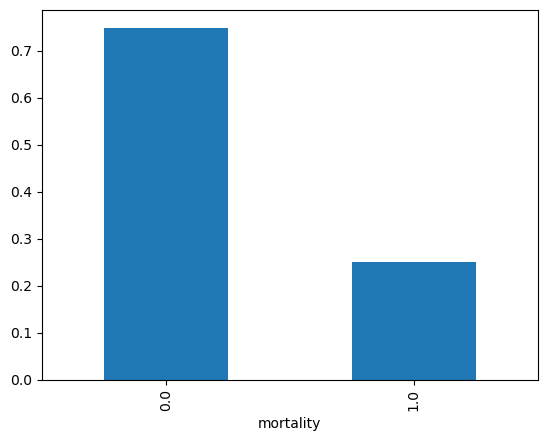

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
x = x.fillna(x.mean(skipna=True)).values
x /= x.mean()
y = df.mortality.values

In [5]:
#def log_logistic_fn(x):
#    return np.log(1+np.exp(-x)) 


class logisticModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __logistic_loss(self,param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*logistic.logcdf(score, loc=0, scale=1) - (1-y)*logistic.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__logistic_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__logistic_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return logistic.cdf(score, loc=0, scale=1)


class probitModel():
    
    def __init__(self):
        self.param = np.zeros(x.shape[1]+1)

    def __probit_loss(self, param, x, y):
        p = param[:-1]
        b = param[-1]
        score = np.dot(x,p) + b
        diff = -y*norm.logcdf(score, loc=0, scale=1) - (1-y)*norm.logcdf(-score, loc=0, scale=1)
        return np.mean(diff)

    def fit(self, x, y):
        loss_values = []

        def callback(param):
            current_loss = self.__probit_loss(param, x, y)
            loss_values.append(current_loss)
            print("Current loss:", current_loss)
        
        result = minimize(self.__probit_loss, self.param, args=(x, y), method='BFGS', tol=1e-3, options={'maxiter':1000}, callback=callback)
        self.param = result.x
        return result, loss_values
    
    def predict(self, x):
        p = self.param[:-1]
        b = self.param[-1]
        score = np.dot(x,p) + b
        return norm.cdf(score, loc=0, scale=1)

In [6]:
probit = probitModel()
result, loss_values = probit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927430849441969
Current loss: 0.6920101815560072
Current loss: 0.6858609345892607
Current loss: 0.6744141959070241
Current loss: 0.6555567679707328
Current loss: 0.6355197730432752
Current loss: 0.6263406461037592
Current loss: 0.6194067428116863
Current loss: 0.6142409076659513
Current loss: 0.6043415953399186
Current loss: 0.5866552758331277
Current loss: 0.5628595864196653
Current loss: 0.5593466508950318
Current loss: 0.5589331796434657
Current loss: 0.558149612427599
Current loss: 0.5520787754656873
Current loss: 0.5499190360384063
Current loss: 0.547229143431688
Current loss: 0.5462303307515513
Current loss: 0.5460148747671772
Current loss: 0.545715261471462
Current loss: 0.5452207029855193
Current loss: 0.5446470358822427
Current loss: 0.544579691893368
Current loss: 0.5445501158189461
Current loss: 0.5444966657809716
Current loss: 0.5443993695755704
Current loss: 0.5442255773599043
Current loss: 0.5439320997024457
Current loss: 0.5435373473112053
Current loss: 

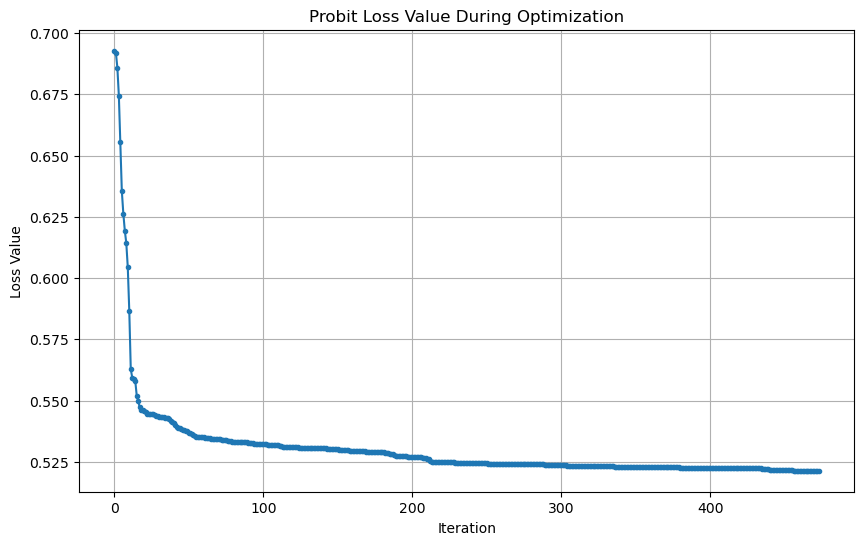

In [7]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

(array([ 344., 1920., 1786.,  921.,  422.,  164.,   57.,   21.,    9.,
           3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

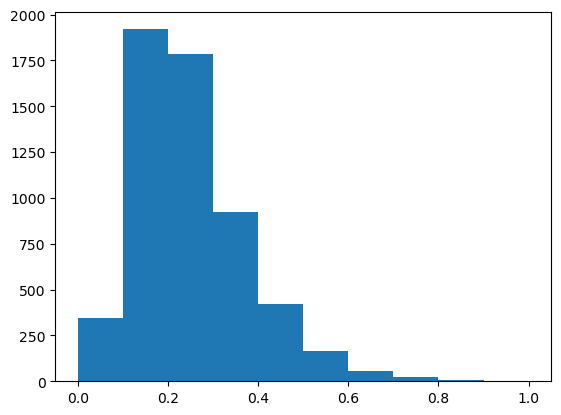

In [8]:
plt.hist(probit.predict(x))

In [9]:
logit = logisticModel()
result, loss_values = logit.fit(x,y)
print("Optimized parameters (b):", result.x)

Current loss: 0.6927794968148143
Current loss: 0.6897525862668715
Current loss: 0.6846150641489323
Current loss: 0.6412695874903189
Current loss: 0.6197338760640024
Current loss: 0.5879432360391693
Current loss: 0.5747297710542044
Current loss: 0.5692222679922667
Current loss: 0.5666178005151807
Current loss: 0.5634633071549277
Current loss: 0.5628223621470703
Current loss: 0.5627432816096835
Current loss: 0.5620764118766902
Current loss: 0.5609964184113865
Current loss: 0.5605664213823317
Current loss: 0.5600051696791752
Current loss: 0.5592841384907206
Current loss: 0.5585817527312442
Current loss: 0.5575696860193171
Current loss: 0.5574905499683771
Current loss: 0.5567463921466279
Current loss: 0.5553705747246096
Current loss: 0.5544774072189647
Current loss: 0.552966703810709
Current loss: 0.5506536047374448
Current loss: 0.5500445758058792
Current loss: 0.5497762253119355
Current loss: 0.5492984249276213
Current loss: 0.5485664545477493
Current loss: 0.5481670785920325
Current los

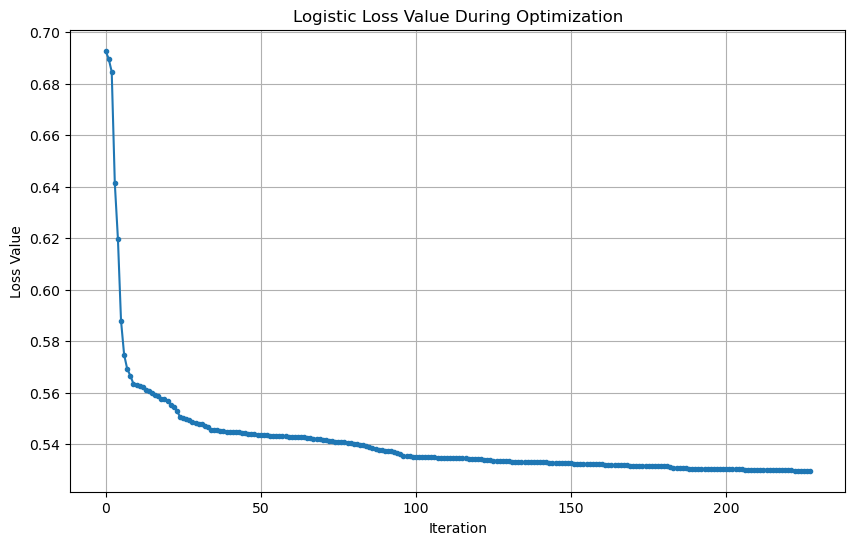

In [10]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

In [15]:
logit.predict(x)

array([0.21802879, 0.19470473, 0.21359502, ..., 0.16214609, 0.23223332,
       0.21606305])

(array([2.200e+02, 1.898e+03, 1.987e+03, 9.340e+02, 3.980e+02, 1.660e+02,
        3.500e+01, 8.000e+00, 0.000e+00, 1.000e+00]),
 array([1.05972483e-40, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

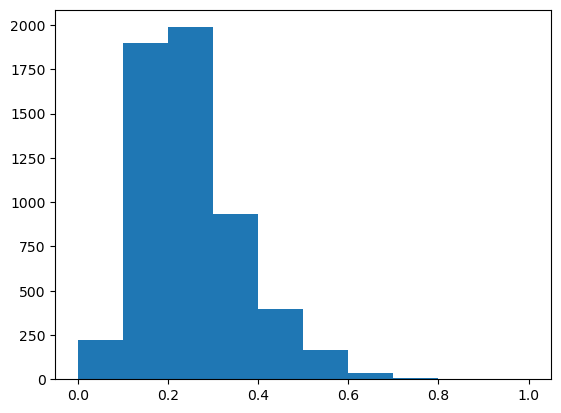

In [16]:
plt.hist(logit.predict(x))

In [17]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x, y)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [18]:
from sklearn.metrics import log_loss

log_loss(y, model.predict_proba(x), eps=1e-15)

0.5363497888711615